# Code for Heart Disease Dataset Prediction
### Author: Rahul Balamurugan
### Date: 4 Feb 2020
### as part of ECE657A Winter 2020 Assignment 1

In [110]:
import pandas as pd
import numpy as np
import seaborn as sb
import sklearn.metrics as metrics
import sklearn.neighbors as neighbors
import scipy.spatial.distance as ssd
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [111]:
df_heart = pd.read_csv('heart_disease_missing.csv')

## Data Cleaning:

In [112]:
#find all missing values
print("Missing values in each feature:\n",df_heart.isnull().sum(),"\n")

Missing values in each feature:
 age          0
sex          0
cp           0
trestbps     7
chol        10
fbs          0
restecg      5
thalach      4
exang        0
oldpeak     12
slope        2
ca           0
thal         1
target       0
dtype: int64 



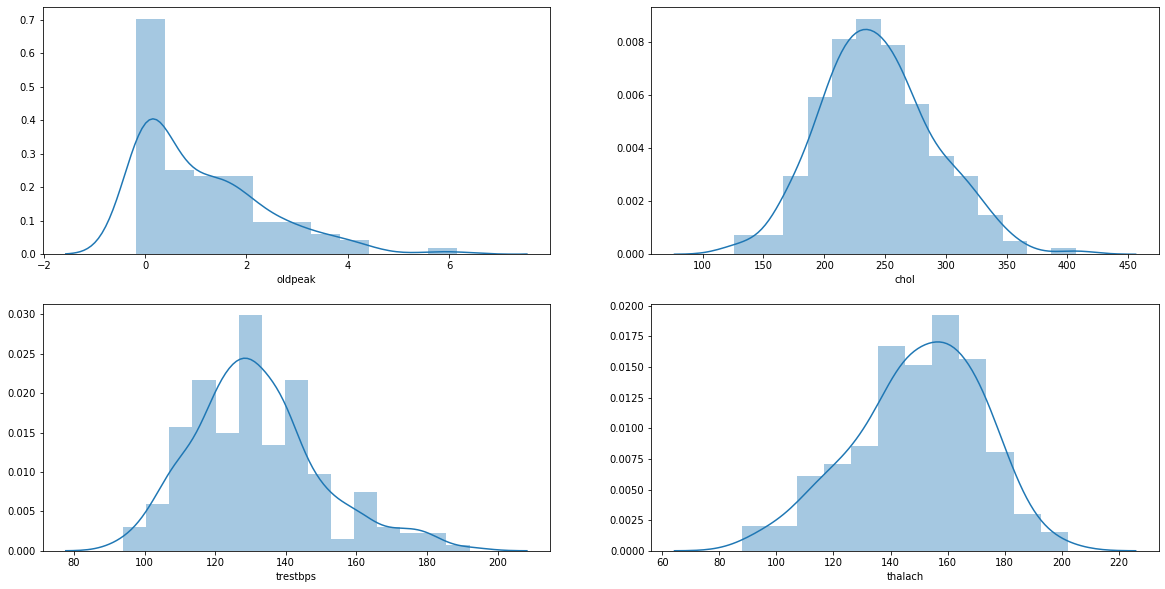

In [113]:
#Get distributions of numerical variables with missing data:
fig = plt.figure(figsize=(20,10))
fig.add_subplot(2,2,1)
sb.distplot(df_heart['oldpeak'])
fig.add_subplot(2,2,2)
sb.distplot(df_heart['chol'])
fig.add_subplot(2,2,3)
sb.distplot(df_heart['trestbps'])
fig.add_subplot(2,2,4)
sb.distplot(df_heart['thalach'])

In [114]:
#Data Summary for understanding:
df_heart.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,212.000000,212.000000,212.000000,205.000000,202.000000,212.000000,207.000000,208.000000,212.000000,200.000000,210.000000,212.000000,211.000000,212.000000
mean,54.311321,0.688679,0.957547,131.784610,244.133256,0.132075,0.560386,149.647978,0.344340,1.113106,1.423810,0.731132,2.349112,0.542453
std,9.145339,0.464130,1.022537,18.057222,46.444257,0.339374,0.535149,22.076206,0.476277,1.255908,0.623622,1.038762,0.602117,0.499374
min,29.000000,0.000000,0.000000,93.944184,126.085811,0.000000,0.000000,88.032613,0.000000,-0.185668,0.000000,0.000000,0.858554,0.000000
25%,47.000000,0.000000,0.000000,119.968114,211.969594,0.000000,0.000000,135.946808,0.000000,0.050778,1.000000,0.000000,1.949795,0.000000
50%,55.000000,1.000000,1.000000,130.010256,241.467023,0.000000,1.000000,151.939216,0.000000,0.726060,1.000000,0.000000,2.078759,1.000000
75%,61.000000,1.000000,2.000000,139.965470,272.484222,0.000000,1.000000,165.260092,1.000000,1.816733,2.000000,1.000000,2.970842,1.000000
max,77.000000,1.000000,3.000000,192.020200,406.932689,1.000000,2.000000,202.138041,1.000000,6.157114,2.000000,4.000000,3.277466,1.000000


In [115]:
#Data Cleaning:

#From distribution of the variables, determine missing data filling method:
df_heart.oldpeak = df_heart.oldpeak.fillna(df_heart.oldpeak.median()) #because skewed
df_heart.chol = df_heart.chol.fillna(df_heart.chol.mean()) #close to normal data
df_heart.trestbps = df_heart.trestbps.fillna(df_heart.trestbps.mode()) #due to presense of outliers and 75%
df_heart.thalach = df_heart.thalach.fillna(df_heart.thalach.median()) #because skewed
df_heart.restecg = df_heart.restecg.fillna(df_heart.restecg.mode()) #as highest count by far is 1

#Drop remaining rows with missing data:
df_heart = df_heart.dropna()

#From data, we can see thal values are noisy; Round to integer:
df_heart.thal = df_heart['thal'].round(decimals=0)

print("Missing values after data cleaning:\n",df_heart.isnull().sum(),"\n")

Missing values after data cleaning:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64 



## Exploratory Data Analysis:

In [116]:
#Find features with least missing data, significant correlation/importance (pairplot,correlation,cramer's V):
#First, separate all features into categories
bins = ['sex', 'fbs', 'exang']
cats = ['cp', 'slope', 'thal']
ords = ['ca']
nums = ['age', 'oldpeak', 'trestbps', 'chol', 'thalach']
target = ['target']

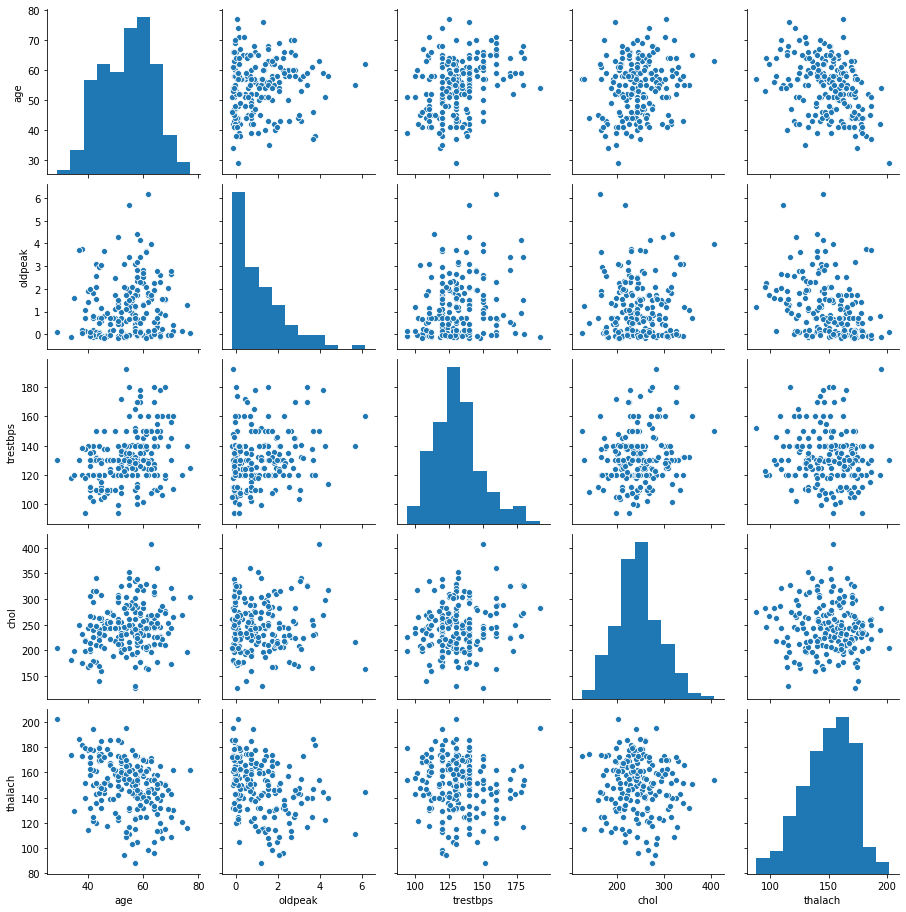

In [117]:
#For all numerical values, do pairplot, boxplots
#First, pair plot:
pplot = sb.pairplot(df_heart, vars=nums, kind="scatter")

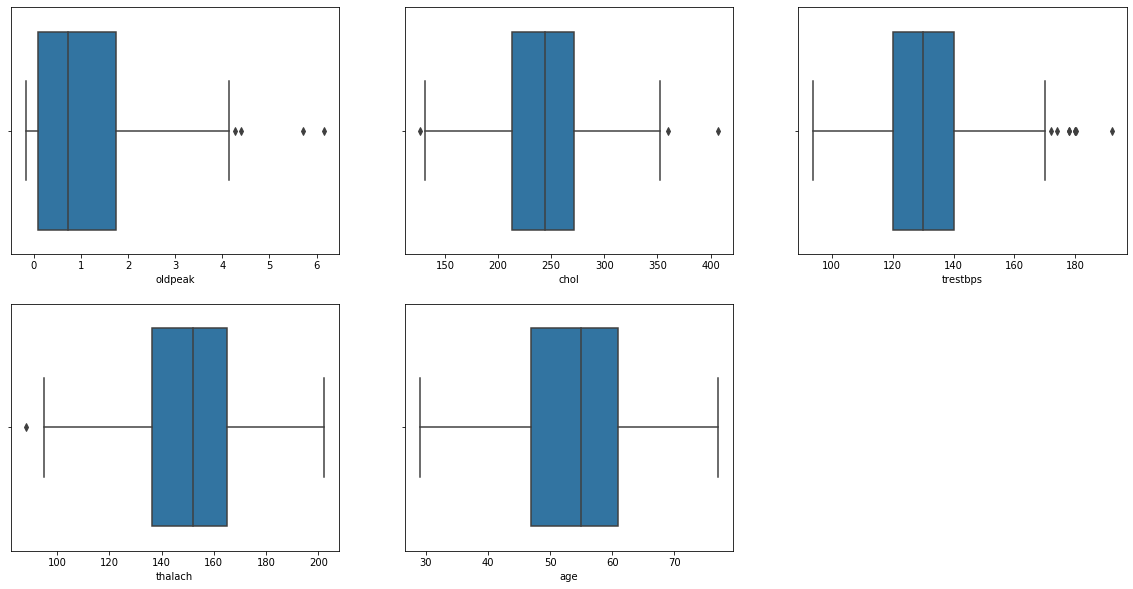

In [118]:
#Boxplots of numerical variables:
fig = plt.figure(figsize=(20,10))
fig.add_subplot(2,3,1)
sb.boxplot(df_heart['oldpeak'])
fig.add_subplot(2,3,2)
sb.boxplot(df_heart['chol'])
fig.add_subplot(2,3,3)
sb.boxplot(df_heart['trestbps'])
fig.add_subplot(2,3,4)
sb.boxplot(df_heart['thalach'])
fig.add_subplot(2,3,5)
sb.boxplot(df_heart['age'])

In [119]:
#Look for associations between categorical variables (including target):
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

a_score = np.empty(shape=(4,4),dtype='object') 
temp = cats+target
for i in range(len(temp)):
    for j in range(len(temp)):
        a_score[i,j] = cramers_v(df_heart[temp[i]],df_heart[temp[j]])
cramers_table = pd.DataFrame(a_score, columns = temp, index = temp)
cramers_table

,cp,slope,thal,target
cp,1,0.198801,0.277788,0.564968
slope,0.198801,1,0.252991,0.443094
thal,0.277788,0.252991,1,0.577346
target,0.564968,0.443094,0.577346,0.990029


In [120]:
#Split dataset into two based on target value
#Plot each corresponding column pair as histogram
df1 = df_heart[df_heart["target"]==1]
df2 = df_heart[df_heart["target"]==0]

Text(0.5, 1.0, 'chol')

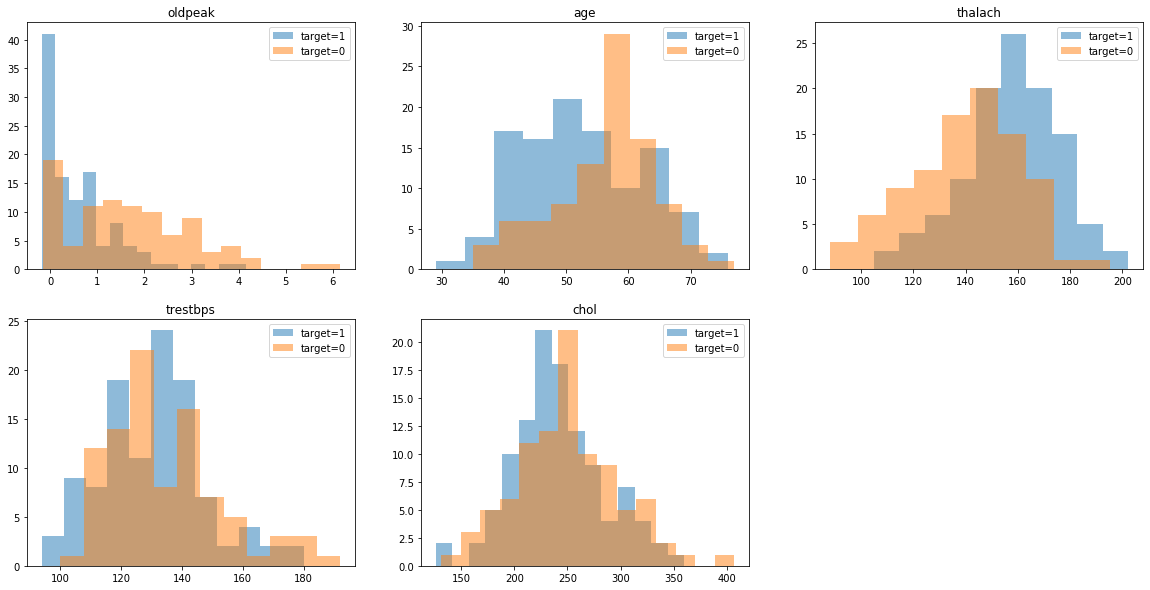

In [121]:
#Plotting only numerical feature histograms:
fig = plt.figure(figsize=(20,10))
fig.add_subplot(2,3,1)
plt.hist(df1['oldpeak'].values,bins=15,alpha=0.5)
plt.hist(df2['oldpeak'].values,bins=15,alpha=0.5)
plt.legend(["target=1","target=0"],loc='upper right')
plt.title("oldpeak")
fig.add_subplot(2,3,2)
plt.hist(df1['age'].values,bins=10,alpha=0.5)
plt.hist(df2['age'].values,bins=10,alpha=0.5)
plt.legend(["target=1","target=0"],loc='upper right')
plt.title('age')
fig.add_subplot(2,3,3)
plt.hist(df1['thalach'].values,bins=10,alpha=0.5)
plt.hist(df2['thalach'].values,bins=10,alpha=0.5)
plt.legend(["target=1","target=0"],loc='upper right')
plt.title('thalach')
fig.add_subplot(2,3,4)
plt.hist(df1['trestbps'].values,bins=12,alpha=0.5)
plt.hist(df2['trestbps'].values,bins=12,alpha=0.5)
plt.legend(["target=1","target=0"],loc='upper right')
plt.title('trestbps')
fig.add_subplot(2,3,5)
plt.hist(df1['chol'].values,bins=15,alpha=0.5)
plt.hist(df2['chol'].values,bins=15,alpha=0.5)
plt.legend(["target=1","target=0"],loc='upper right')
plt.title('chol')

Text(0.5, 1.0, 'thal')

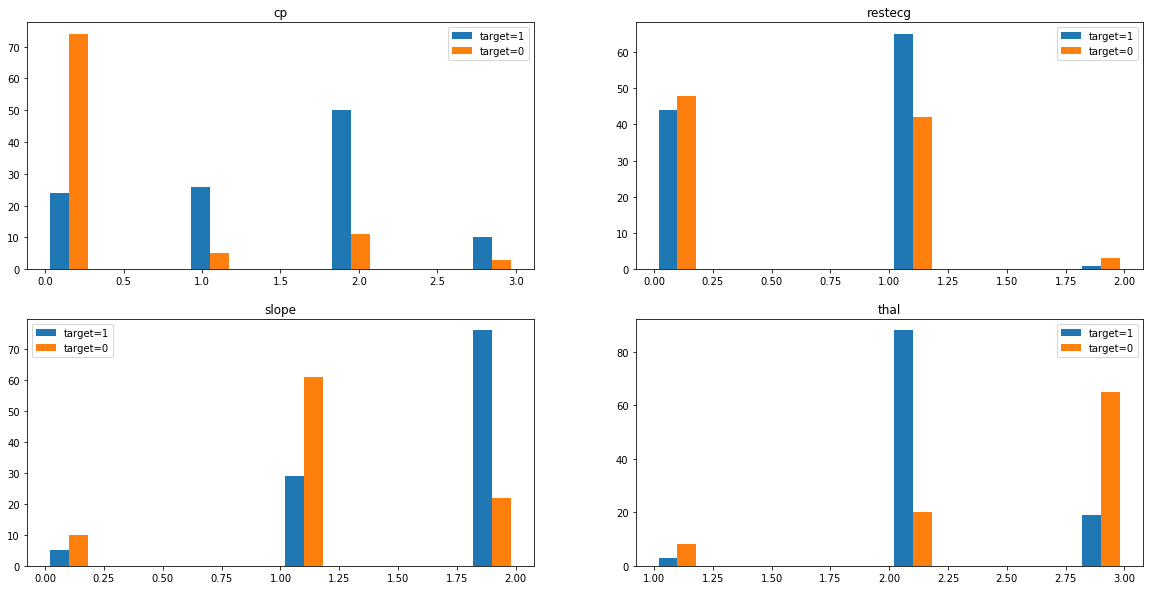

In [122]:
#Plotting Categorical features histograms:
fig = plt.figure(figsize=(20,10))
fig.add_subplot(2,2,1)
plt.hist([df1['cp'].values,df2['cp'].values])
plt.legend(["target=1","target=0"],loc='upper right')
plt.title('cp')
fig.add_subplot(2,2,2)
plt.hist([df1['restecg'].values,df2['restecg'].values])
plt.legend(["target=1","target=0"],loc='upper right')
plt.title('restecg')
fig.add_subplot(2,2,3)
plt.hist([df1['slope'].values,df2['slope'].values])
plt.legend(["target=1","target=0"],loc='upper left')
plt.title('slope')
fig.add_subplot(2,2,4)
plt.hist([df1['thal'].values,df2['thal'].values])
plt.legend(["target=1","target=0"],loc='upper right')
plt.title('thal')

Text(0.5, 1.0, 'ca')

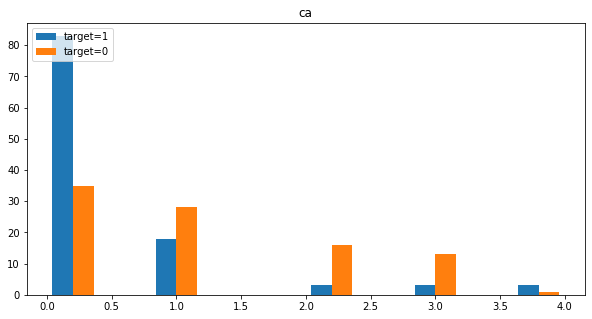

In [123]:
#Plotting Ordinal feature histogram
fig = plt.figure(figsize=(10,5))
plt.hist([df1['ca'].values,df2['ca'].values])
plt.legend(["target=1","target=0"],loc='upper left')
plt.title('ca')

Text(0.5, 1.0, 'exang')

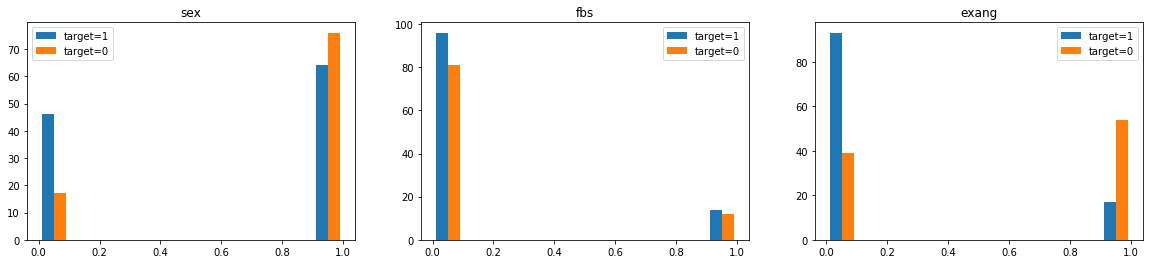

In [124]:
#Plotting binary features histograms
fig = plt.figure(figsize=(20,4))

fig.add_subplot(1,3,1)
plt.hist([df1['sex'].values,df2['sex'].values])
plt.legend(["target=1","target=0"],loc='upper left')
plt.title('sex')

fig.add_subplot(1,3,2)
plt.hist([df1['fbs'].values,df2['fbs'].values])
plt.legend(["target=1","target=0"],loc='upper right')
plt.title('fbs')

fig.add_subplot(1,3,3)
plt.hist([df1['exang'].values,df2['exang'].values])
plt.legend(["target=1","target=0"],loc='upper right')
plt.title('exang')

In [125]:
#Correlation of all the numerical features:
df = df_heart[["oldpeak","trestbps","chol","age","thalach"]].copy()
df.corr()

,oldpeak,trestbps,chol,age,thalach
oldpeak,1.000000,0.162375,0.058313,0.119999,-0.351220
trestbps,0.162375,1.000000,0.151521,0.329902,-0.092065
chol,0.058313,0.151521,1.000000,0.177698,-0.049592
age,0.119999,0.329902,0.177698,1.000000,-0.377085
thalach,-0.351220,-0.092065,-0.049592,-0.377085,1.000000


In [126]:
index = ['mean','variance','skewness','kurtosis']
cols_heart = df_heart.columns
mean_heart = df_heart.mean().to_list()
var_heart = df_heart.var().to_list()
skew_heart = df_heart.skew().to_list()
kurt_heart = df_heart.kurtosis().to_list()
stats_heart = pd.DataFrame([mean_heart,var_heart,skew_heart,kurt_heart],columns=cols_heart,index=index)
stats_heart

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
mean,54.275862,0.689655,0.945813,132.000009,244.879500,0.128079,0.566502,149.668655,0.349754,1.102143,1.408867,0.729064,2.359606,0.541872
variance,84.101741,0.215090,1.041604,322.669005,2094.464088,0.112227,0.286397,462.899473,0.228552,1.481404,0.391406,1.099498,0.340340,0.249476
skewness,-0.108658,-0.826008,0.476134,0.686186,0.318826,2.242494,0.123090,-0.400313,0.634806,1.294221,-0.568742,1.394505,-0.267110,-0.169332
kurtosis,-0.540345,-1.330922,-1.234282,0.630104,0.388258,3.058819,-1.170850,-0.137873,-1.613011,1.707478,-0.595728,1.032442,-0.688679,-1.991041


## Getting training and testing data:

In [127]:
#Reconstruct dataframe with only chosen feature subset:
df = df_heart[["cp","oldpeak","thal","ca","thalach","target"]].copy()
#df.cp = df.cp.replace({0:'Asympt.', 1:'Atypical', 2:'Non', 3:'Typical'})
#df.thal = df.thal.replace({0:'NA', 1:'Fixed', 2:'Normal', 3:'Revers.'})

In [128]:
X = df.drop(columns=['target']).to_numpy()
y = df['target'].to_list()

In [129]:
#Split into training, testing, and validation sets (60%,20%,20%):
X_1,X_test,y_1,y_test = train_test_split(X,y,test_size=0.20,random_state=275)
X_train,X_val,y_train,y_val = train_test_split(X_1,y_1,test_size=0.25,random_state=275)

## Setting baseline score using default kNN classifier:

In [130]:
#Train kNN Classifier with default parameters:
knn = neighbors.KNeighborsClassifier()
#Fit Classifier to training dataset:
knn.fit(X_train,y_train)
#Use model to predict species of testing dataset:
y0 = knn.predict(X_test)
#Get accuracy score of model:
acc0 = metrics.accuracy_score(y_test,y0)
acc0

0.7317073170731707

## Optimizing k (given range) for default classifier:

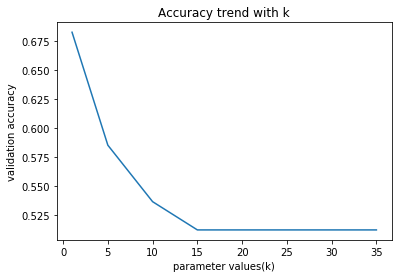

In [131]:
#Test for best parameter k from given values (all other hyperparameters=default) on validation set:
k = [1,5,10,15,20,25,30,35]
j = 0
acc_val = [0,0,0,0,0,0,0,0]
for i in k:
    knn = neighbors.KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    y0 = knn.predict(X_val)
    acc_val[j] = metrics.accuracy_score(y_val,y0)
    j=j+1
plt.plot(k,acc_val)
plt.xlabel('parameter values(k)')
plt.ylabel('validation accuracy')
plt.title('Accuracy trend with k')
plt.show()

In [132]:
#Test model with identified parameter 'k' on testing set:
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
y1 = knn.predict(X_test)
acc1 = metrics.accuracy_score(y_test,y1)
auc1 = metrics.roc_auc_score(y,knn.predict(X),multi_class='ovr')
f1 = metrics.f1_score(y_test,y1,average='macro')
print("\nkNN Model performance (k=5):\n")
print("\nAccuracy = ",acc1,"\nAUC = ",auc1,"\nF-score = ",f1)


kNN Model performance (k=5):


Accuracy =  0.7317073170731707 
AUC =  0.7291788856304986 
F-score =  0.7291291291291292


## Improved Model:

In [133]:
#Improved Model:
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import GridSearchCV

Xn_train = X_1
yn_train = y_1

#Fit and transform training set values:
Xn_train = minmax_scale(Xn_train)
X_test = minmax_scale(X_test)

In [134]:
#Use GridSearchCV to compare hyperparameters for best fit:
#Define dictionary of hyperparameters-
params = dict(n_neighbors = [1,5,10,15,20,25,30,35],leaf_size=list(range(20,40)),weights=['uniform','distance'],p=[1,2,3])

kNN_model = neighbors.KNeighborsClassifier()

#The grid_search object-
grid_search = GridSearchCV(kNN_model,params)

Best_kNN_model = grid_search.fit(Xn_train,yn_train)
Best = Best_kNN_model.best_estimator_.get_params()
#The best parameters are therefore:
print("Best parameters found through exhaustive grid search:\n")
print("k = ",Best['n_neighbors'],"\nleaf size = ", Best['leaf_size'],"\nweights = ",Best['weights'],"\np = ",Best['p'])

Best parameters found through exhaustive grid search:

k =  15 
leaf size =  20 
weights =  uniform 
p =  1


In [135]:
print('Best Score - KNN:', grid_search.best_score_) 

Best Score - KNN: 0.8515151515151516


In [136]:
#Testing the parameters using testing dataset:
knn = neighbors.KNeighborsClassifier(n_neighbors=15,leaf_size=20,weights='uniform',p=1)
knn.fit(Xn_train,yn_train)
y1 = knn.predict(X_test)
acc1 = metrics.accuracy_score(y_test,y1)
auc1 = metrics.roc_auc_score(y,knn.predict(X),multi_class='ovr')
f1 = metrics.f1_score(y_test,y1,average='macro')
print("\nkNN Model performance:\n")
print("\nAccuracy = ",acc1,"\nAUC = ",auc1,"\nF-score = ",f1)


kNN Model performance:


Accuracy =  0.8536585365853658 
AUC =  0.7875366568914955 
F-score =  0.849264705882353
